# Monte Carlo Convergence Analysis for Barrier Options

This notebook demonstrates how the estimated price of a barrier option and its associated Monte Carlo error converge as the number of simulation paths increases.

## Why Convergence Analysis?

Monte Carlo methods are statistical sampling techniques. The accuracy of the estimated option price depends on the number of simulated paths:
- As the number of simulations ($N_{sim}$) increases, the sample mean of the discounted payoffs should converge to the true expected value.
- The standard error of the Monte Carlo estimate typically decreases at a rate of $1/\sqrt{N_{sim}}$.

Visualizing this convergence helps in:
1.  **Determining an adequate number of simulations:** For a desired level of precision.
2.  **Understanding the stability of the estimate:** How much the price fluctuates with fewer simulations versus more.
3.  **Verifying the $1/\sqrt{N_{sim}}$ error reduction trend** (often best seen on a log-log plot for the error).

We will use the `BarrierOptionsPricer` class and its `analyze_convergence` method.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Union, Optional, List, Dict # Added List, Dict
import time

# For confidence interval calculation - ensure scipy is installed
try:
    from scipy import stats
except ImportError:
    print("Warning: scipy.stats not found. Using a basic approximation for confidence interval critical values.")
    class stats_fallback: # Renamed to avoid conflict if scipy.stats is actually imported
        class norm:
            @staticmethod
            def ppf(q):
                if abs(q - 0.975) < 1e-3: return 1.96
                elif abs(q - 0.995) < 1e-3: return 2.576
                import math # Lazy import math if needed
                return math.sqrt(2) * math.erfcinv(2.0 - 2.0*q) if q > 0 and q < 1 else 0 # More robust approximation
    stats = stats_fallback

# Set a seed for reproducibility
np.random.seed(123)


## BarrierOptionsPricer Class and Helper Functions

The following cell contains the full `BarrierOptionsPricer` class definition and the `print_detailed_results` helper function from the `barrier_options_pricer.py` file. We include them here to make the notebook self-contained and runnable.


In [2]:
class BarrierOptionsPricer:
    """
    Monte Carlo pricer for barrier options using Geometric Brownian Motion.
    """
    
    def __init__(self):
        self.valid_option_types = [
            'down_and_out_call', 'down_and_out_put',
            'up_and_out_call', 'up_and_out_put',
            'down_and_in_call', 'down_and_in_put',
            'up_and_in_call', 'up_and_in_put'
        ]
    
    def simulate_gbm_paths(self, S0: float, r: float, sigma: float, T: float, 
                          N_sim: int, N_steps: int) -> np.ndarray:
        dt = T / N_steps
        drift = (r - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt)
        random_shocks = np.random.normal(0, 1, (N_sim, N_steps))
        paths = np.zeros((N_sim, N_steps + 1))
        paths[:, 0] = S0
        for i in range(N_steps):
            paths[:, i + 1] = paths[:, i] * np.exp(drift + diffusion * random_shocks[:, i])
        return paths
    
    def apply_continuity_correction(self, B: float, sigma: float, T: float, 
                                  N_steps: int, option_type: str) -> float:
        dt = T / N_steps
        beta_correction_factor = 0.5826 
        correction_amount = beta_correction_factor * sigma * np.sqrt(dt)
        B_adj = B
        if 'down' in option_type:
            if 'out' in option_type: B_adj = B * np.exp(-correction_amount)
            else: B_adj = B * np.exp(correction_amount)
        elif 'up' in option_type:
            if 'out' in option_type: B_adj = B * np.exp(correction_amount)
            else: B_adj = B * np.exp(-correction_amount)
        return B_adj
    
    def calculate_barrier_payoff(self, path: np.ndarray, K: float, B: float, 
                               option_type: str, T: float, r_rate: float,
                               monitoring_type: str = 'discrete', sigma_for_correction: Optional[float] = None) -> float:
        if option_type not in self.valid_option_types:
            raise ValueError(f"Invalid option type. Must be one of {self.valid_option_types}")
        B_eff = B
        if monitoring_type == 'continuous_approx':
            if sigma_for_correction is None:
                raise ValueError("sigma_for_correction must be provided for continuous_approx monitoring.")
            N_steps = len(path) - 1
            B_eff = self.apply_continuity_correction(B, sigma_for_correction, T, N_steps, option_type)
        knocked_out, knocked_in = False, False
        if ('down_and_out' in option_type and path[0] <= B_eff) or \
           ('up_and_out' in option_type and path[0] >= B_eff):
            return 0.0
        for price_step in path:
            if 'down' in option_type and price_step <= B_eff:
                if 'out' in option_type: knocked_out = True; break
                if 'in' in option_type: knocked_in = True; break
            elif 'up' in option_type and price_step >= B_eff:
                if 'out' in option_type: knocked_out = True; break
                if 'in' in option_type: knocked_in = True; break
        S_T = path[-1]
        intrinsic_payoff = max(S_T - K, 0) if 'call' in option_type else max(K - S_T, 0)
        payoff = 0.0
        if 'out' in option_type and not knocked_out: payoff = intrinsic_payoff
        elif 'in' in option_type and knocked_in: payoff = intrinsic_payoff
        return payoff

    def monte_carlo_pricer(self, S0: float, K: float, B: float, T: float,
                          r_rate: float, sigma: float, option_type: str,
                          N_sim: int, N_steps: int,
                          monitoring_type: str = 'discrete',
                          confidence_level: float = 0.95,
                          antithetic: bool = False) -> Tuple[float, float, float, dict]:
        start_time = time.time()
        actual_N_sim_for_shocks = N_sim
        if antithetic:
            actual_N_sim_for_shocks = (N_sim + 1) // 2 if N_sim % 2 != 0 else N_sim // 2
        
        dt = T / N_steps
        drift = (r_rate - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt)
        random_shocks_orig = np.random.normal(0, 1, (actual_N_sim_for_shocks, N_steps))
        all_payoffs = []

        paths_orig = np.zeros((actual_N_sim_for_shocks, N_steps + 1))
        paths_orig[:, 0] = S0
        for i in range(N_steps):
            paths_orig[:, i + 1] = paths_orig[:, i] * np.exp(drift + diffusion * random_shocks_orig[:, i])
        for j in range(actual_N_sim_for_shocks):
            payoff_orig = self.calculate_barrier_payoff(paths_orig[j,:], K, B, option_type, T, r_rate, monitoring_type, sigma)
            all_payoffs.append(payoff_orig)

        if antithetic:
            random_shocks_anti = -random_shocks_orig
            paths_anti = np.zeros((actual_N_sim_for_shocks, N_steps + 1))
            paths_anti[:, 0] = S0
            for i in range(N_steps):
                paths_anti[:, i + 1] = paths_anti[:, i] * np.exp(drift + diffusion * random_shocks_anti[:, i])
            for j in range(actual_N_sim_for_shocks):
                payoff_anti = self.calculate_barrier_payoff(paths_anti[j,:], K, B, option_type, T, r_rate, monitoring_type, sigma)
                all_payoffs.append(payoff_anti)
        
        all_payoffs_arr = np.array(all_payoffs)
        mean_payoff = np.mean(all_payoffs_arr)
        option_price = mean_payoff * np.exp(-r_rate * T)
        
        std_payoffs = np.std(all_payoffs_arr, ddof=1) if len(all_payoffs_arr) > 1 else 0.0
        n_total_effective_paths = len(all_payoffs_arr)
        standard_error_payoff = std_payoffs / np.sqrt(n_total_effective_paths) if n_total_effective_paths > 0 else 0.0
        
        alpha_ci = 1 - confidence_level
        critical_value = stats.norm.ppf(1 - alpha_ci/2)
        margin_of_error_price = critical_value * standard_error_payoff * np.exp(-r_rate * T)
        confidence_lower = option_price - margin_of_error_price
        confidence_upper = option_price + margin_of_error_price
        
        computation_time = time.time() - start_time
        mc_error_price_val = standard_error_payoff * np.exp(-r_rate * T)
        
        barrier_hit_count = 0
        combined_paths_for_stats = paths_orig
        if antithetic and actual_N_sim_for_shocks > 0: # Reconstruct anti paths for stats if not already available
            paths_anti_for_stats = np.zeros((actual_N_sim_for_shocks, N_steps + 1))
            paths_anti_for_stats[:, 0] = S0
            for k_sim in range(actual_N_sim_for_shocks):
                 for i in range(N_steps):
                    paths_anti_for_stats[k_sim, i + 1] = paths_anti_for_stats[k_sim, i] * np.exp(drift + diffusion * (-random_shocks_orig[k_sim, i])) # Use original negated shocks
            combined_paths_for_stats = np.vstack((paths_orig, paths_anti_for_stats))

        for path_stat in combined_paths_for_stats:
            B_eff_stat = B
            if monitoring_type == 'continuous_approx':
                 B_eff_stat = self.apply_continuity_correction(B, sigma, T, N_steps, option_type)
            hit_this_path = False
            if 'down' in option_type:
                if np.any(path_stat <= B_eff_stat): hit_this_path = True
            elif 'up' in option_type:
                if np.any(path_stat >= B_eff_stat): hit_this_path = True
            if hit_this_path: barrier_hit_count +=1
        
        barrier_hit_percentage = (barrier_hit_count / len(combined_paths_for_stats)) * 100 if len(combined_paths_for_stats) > 0 else 0.0

        statistics = {
            'mean_payoff': mean_payoff, 'std_payoff': std_payoffs,
            'standard_error_payoff': standard_error_payoff, 'mc_error_price': mc_error_price_val,
            'barrier_hit_percentage': barrier_hit_percentage, 'computation_time': computation_time,
            'effective_simulations_used': n_total_effective_paths, 'confidence_used': confidence_level,
            'convergence_ratio': mc_error_price_val / option_price if abs(option_price) > 1e-9 else float('inf')
        }
        return option_price, confidence_lower, confidence_upper, statistics

    def analyze_convergence(self, S0: float, K: float, B: float, T: float,
                           r_rate: float, sigma: float, option_type: str,
                           N_steps: int, sim_counts: Optional[List[int]] = None,
                           monitoring_type: str = 'discrete', antithetic: bool = False) -> Dict:
        """
        Analyze convergence of the Monte Carlo estimate as number of simulations increases.
        """
        if sim_counts is None:
            sim_counts = [1000, 5000, 10000, 20000, 50000, 100000, 200000, 500000] # Expanded list
        
        prices, errors, times = [], [], []
        
        print(f"Starting convergence analysis for {option_type}...")
        for N_sim_val in sim_counts:
            print(f"  Running with N_sim = {N_sim_val:,}")
            price, _, _, stats = self.monte_carlo_pricer(
                S0, K, B, T, r_rate, sigma, option_type, N_sim_val, N_steps, monitoring_type, antithetic=antithetic
            )
            prices.append(price)
            errors.append(stats['mc_error_price']) # Use SEM of price
            times.append(stats['computation_time'])
        print("Convergence analysis complete.")
        
        return {
            'sim_counts': sim_counts, 'prices': prices, 
            'errors': errors, 'computation_times': times
        }

# Helper function to print results neatly (can be omitted if not needed for this notebook's focus)
def print_detailed_results(price: float, conf_lower: float, conf_upper: float, 
                          stats: dict, option_params: dict):
    """Print detailed results of the barrier option pricing."""
    print("\n" + "="*60)
    print("BARRIER OPTION PRICING RESULTS (Single Run)")
    print("="*60)
    print(f"\nOption Type: {option_params['option_type'].replace('_', ' ').title()}")
    # ... (rest of the print_detailed_results function can be included if desired for individual checks)
    print(f"Estimated Option Price: ${price:.6f}")
    print(f"{stats['confidence_used']*100:.0f}% Confidence Interval: [${conf_lower:.6f}, ${conf_upper:.6f}]")
    print(f"Monte Carlo Error (SEM of Price): ±${stats['mc_error_price']:.6f}")
    if abs(price) > 1e-9:
        print(f"MC Error as % of Price: {(stats['mc_error_price']/price)*100:.3f}%")
    print(f"Computation Time: {stats['computation_time']:.3f} seconds")



## Define Parameters for Analysis

We'll choose a specific barrier option and its parameters to analyze.


In [3]:
# Parameters for the option to be analyzed
analysis_params = {
    'S0': 100.0,
    'K': 100.0,
    'B': 90.0,
    'T': 1.0,
    'r_rate': 0.05,
    'sigma': 0.2,
    'option_type': 'down_and_out_call', # A common barrier option
    'N_steps': 252, # Daily monitoring for 1 year
    'monitoring_type': 'discrete',
    'antithetic': False # Can be set to True to see its effect on convergence
}

# Simulation counts to test
# Using a logarithmic-like scale to see convergence over orders of magnitude
simulation_counts = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]

print("Parameters for Convergence Analysis:")
for key, value in analysis_params.items():
    print(f"- {key}: {value}")
print(f"- Simulation Counts: {simulation_counts}")


Parameters for Convergence Analysis:
- S0: 100.0
- K: 100.0
- B: 90.0
- T: 1.0
- r_rate: 0.05
- sigma: 0.2
- option_type: down_and_out_call
- N_steps: 252
- monitoring_type: discrete
- antithetic: False
- Simulation Counts: [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]


In [4]:
# Parameters for the option to be analyzed
analysis_params = {
    'S0': 100.0,
    'K': 100.0,
    'B': 90.0,
    'T': 1.0,
    'r_rate': 0.05,
    'sigma': 0.2,
    'option_type': 'down_and_out_call', # A common barrier option
    'N_steps': 252, # Daily monitoring for 1 year
    'monitoring_type': 'discrete',
    'antithetic': False # Can be set to True to see its effect on convergence
}

# Simulation counts to test
# Using a logarithmic-like scale to see convergence over orders of magnitude
simulation_counts = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]

print("Parameters for Convergence Analysis:")
for key, value in analysis_params.items():
    print(f"- {key}: {value}")
print(f"- Simulation Counts: {simulation_counts}")


Parameters for Convergence Analysis:
- S0: 100.0
- K: 100.0
- B: 90.0
- T: 1.0
- r_rate: 0.05
- sigma: 0.2
- option_type: down_and_out_call
- N_steps: 252
- monitoring_type: discrete
- antithetic: False
- Simulation Counts: [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]


## Run Convergence Analysis

Instantiate the pricer and call the `analyze_convergence` method.


In [5]:
pricer_analyzer = BarrierOptionsPricer()

convergence_results = pricer_analyzer.analyze_convergence(
    S0=analysis_params['S0'],
    K=analysis_params['K'],
    B=analysis_params['B'],
    T=analysis_params['T'],
    r_rate=analysis_params['r_rate'],
    sigma=analysis_params['sigma'],
    option_type=analysis_params['option_type'],
    N_steps=analysis_params['N_steps'],
    sim_counts=simulation_counts,
    monitoring_type=analysis_params['monitoring_type'],
    antithetic=analysis_params['antithetic']
)


Starting convergence analysis for down_and_out_call...
  Running with N_sim = 1,000
  Running with N_sim = 2,000
  Running with N_sim = 5,000
  Running with N_sim = 10,000
  Running with N_sim = 20,000
  Running with N_sim = 50,000
  Running with N_sim = 100,000
  Running with N_sim = 200,000
  Running with N_sim = 500,000
  Running with N_sim = 1,000,000
Convergence analysis complete.


## Plotting Convergence Results

We will create two plots:
1.  Estimated Option Price vs. Number of Simulations.
2.  Monte Carlo Error (Standard Error of the Mean Price) vs. Number of Simulations (on a log-log scale to observe the $1/\sqrt{N}$ trend).


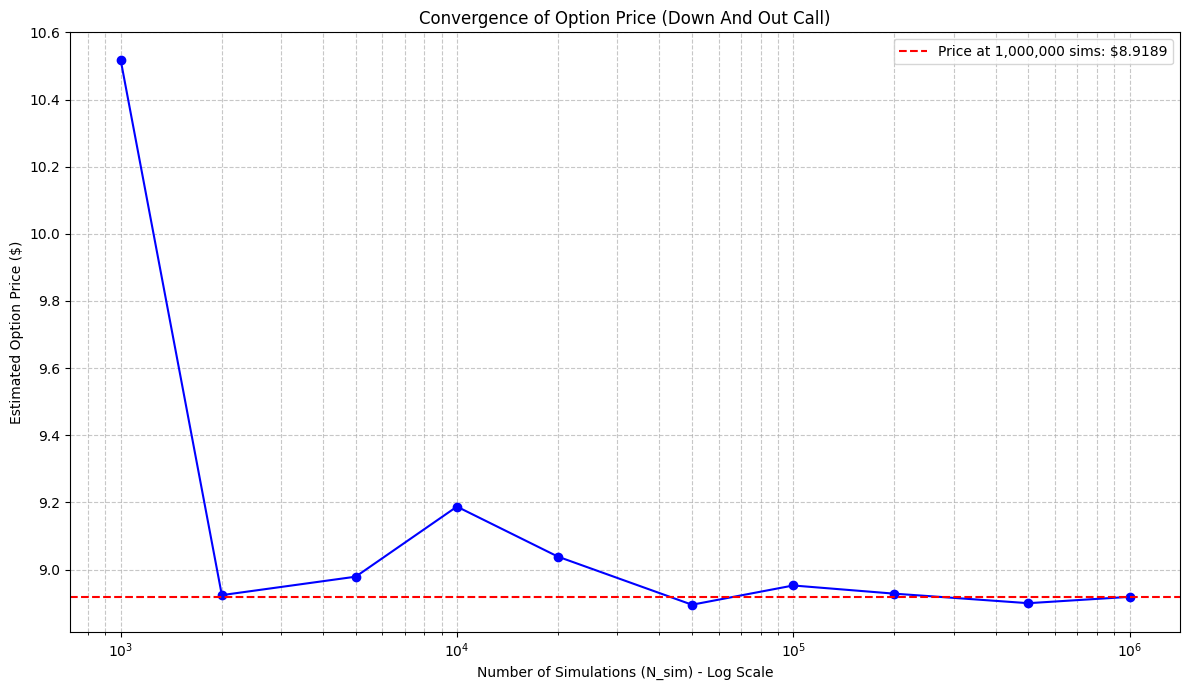

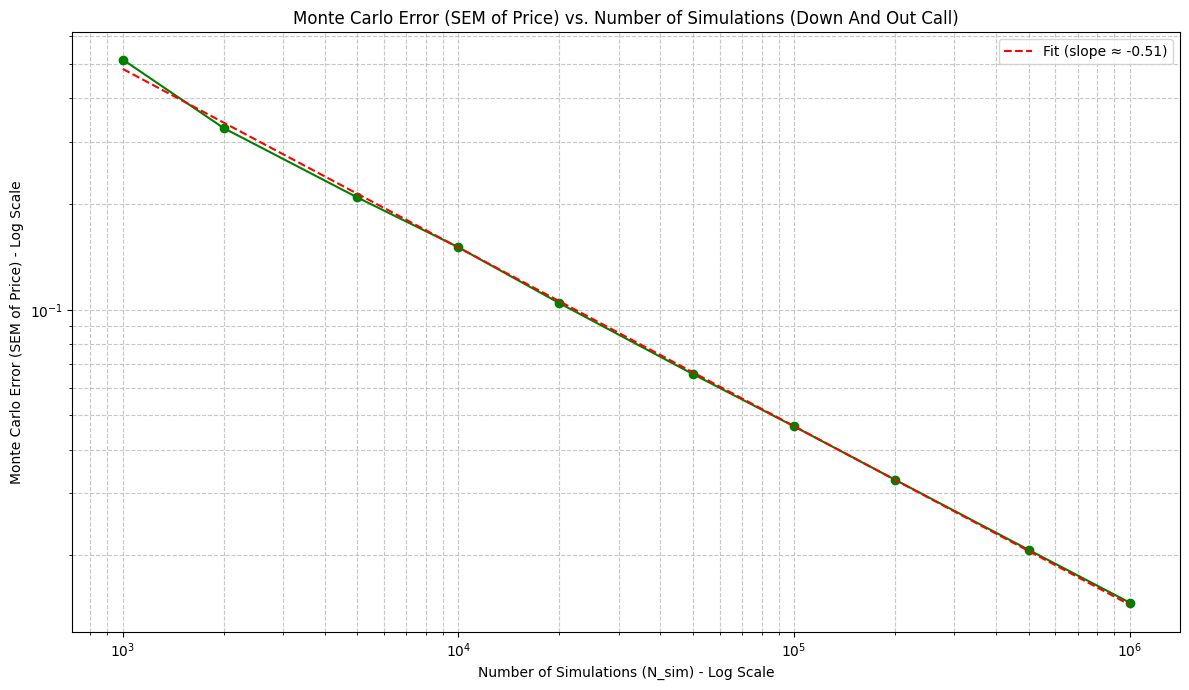

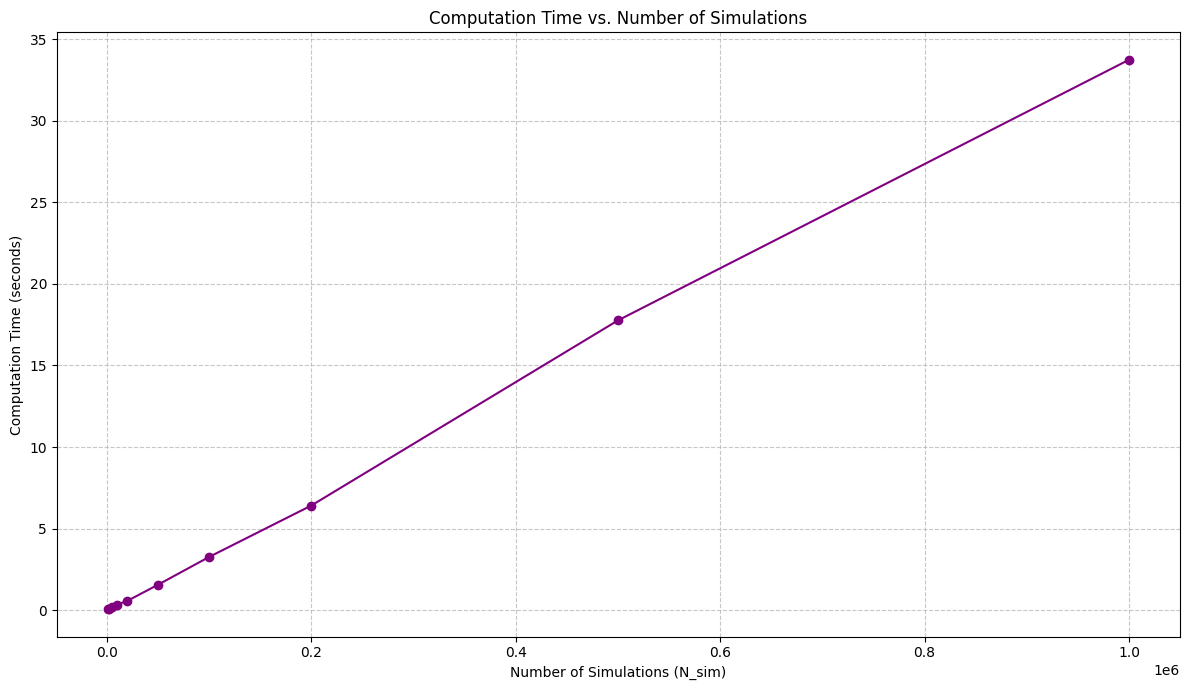

\nSummary of Convergence Data:
--------------------------------------------------
Simulations     Price ($)       MC Error ($)    Time (s)  
--------------------------------------------------
1,000           10.518889       0.515334        0.076     
2,000           8.924022        0.328755        0.063     
5,000           8.978947        0.208733        0.183     
10,000          9.187602        0.150588        0.342     
20,000          9.038350        0.104385        0.569     
50,000          8.895437        0.065581        1.559     
100,000         8.952728        0.046561        3.262     
200,000         8.928349        0.032818        6.414     
500,000         8.900027        0.020731        17.762    
1,000,000       8.918904        0.014668        33.738    


In [6]:
# Extract results for plotting
sim_counts_res = convergence_results['sim_counts']
prices_res = convergence_results['prices']
errors_res = convergence_results['errors']
times_res = convergence_results['computation_times']

# Plot 1: Option Price vs. Number of Simulations
plt.figure(figsize=(12, 7))
plt.plot(sim_counts_res, prices_res, marker='o', linestyle='-', color='b')
plt.xscale('log') # Use log scale for x-axis to better see behavior over orders of magnitude
plt.title(f'Convergence of Option Price ({analysis_params["option_type"].replace("_", " ").title()})')
plt.xlabel('Number of Simulations (N_sim) - Log Scale')
plt.ylabel('Estimated Option Price ($)')
plt.grid(True, which="both", ls="--", alpha=0.7)
# Add a horizontal line for the price at the highest N_sim as a reference
if len(prices_res) > 0:
    plt.axhline(prices_res[-1], color='r', linestyle='--', label=f'Price at {sim_counts_res[-1]:,} sims: ${prices_res[-1]:.4f}')
    plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Monte Carlo Error vs. Number of Simulations (Log-Log Scale)
plt.figure(figsize=(12, 7))
plt.plot(sim_counts_res, errors_res, marker='o', linestyle='-', color='g')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Monte Carlo Error (SEM of Price) vs. Number of Simulations ({analysis_params["option_type"].replace("_", " ").title()})')
plt.xlabel('Number of Simulations (N_sim) - Log Scale')
plt.ylabel('Monte Carlo Error (SEM of Price) - Log Scale')
plt.grid(True, which="both", ls="--", alpha=0.7)

# Fit a line to check for 1/sqrt(N) behavior (slope of -0.5 on log-log)
# log(error) = log(C) - 0.5 * log(N)
if len(sim_counts_res) > 1 and len(errors_res) > 1:
    # Use valid (non-zero, non-NaN) errors for fitting
    valid_indices = [i for i, e in enumerate(errors_res) if e > 0 and not np.isnan(e)]
    if len(valid_indices) > 1:
        log_N = np.log(np.array(sim_counts_res)[valid_indices])
        log_error = np.log(np.array(errors_res)[valid_indices])
        coeffs = np.polyfit(log_N, log_error, 1)
        slope = coeffs[0]
        fit_line = np.exp(coeffs[1] + slope * np.log(sim_counts_res)) # Use original sim_counts for plotting line
        plt.plot(sim_counts_res, fit_line, 'r--', label=f'Fit (slope ≈ {slope:.2f})')
        plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Computation Time vs. Number of Simulations
plt.figure(figsize=(12, 7))
plt.plot(sim_counts_res, times_res, marker='o', linestyle='-', color='purple')
# plt.xscale('log') # Optional: log scale for x if desired
plt.title('Computation Time vs. Number of Simulations')
plt.xlabel('Number of Simulations (N_sim)')
plt.ylabel('Computation Time (seconds)')
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()

print("\\nSummary of Convergence Data:")
print("-" * 50)
print(f"{'Simulations':<15} {'Price ($)':<15} {'MC Error ($)':<15} {'Time (s)':<10}")
print("-" * 50)
for i in range(len(sim_counts_res)):
    print(f"{sim_counts_res[i]:<15,} {prices_res[i]:<15.6f} {errors_res[i]:<15.6f} {times_res[i]:<10.3f}")


## Conclusion and Observations

From the plots, we can observe:
- **Price Convergence:** The estimated option price tends to stabilize as the number of simulations increases. The fluctuations are larger for smaller $N_{sim}$.
- **Error Reduction:** The Monte Carlo error (Standard Error of the Mean price) decreases as $N_{sim}$ increases. On a log-log scale, this error should ideally exhibit a slope of approximately -0.5, consistent with the $1/\sqrt{N_{sim}}$ convergence rate of standard Monte Carlo methods.
- **Computation Time:** Computation time generally increases linearly with the number of simulations.

This analysis is crucial for understanding the trade-off between computational cost and the desired accuracy of the Monte Carlo estimate. For important pricing tasks, a higher number of simulations is typically used to achieve a smaller error and a more reliable price.
